In [3]:
# define id (full id account) -> full WMS intance ID
INSTANCE_ID = '042dbf75-1db4-48af-aa2c-beee173d3339'  
# aldready inputted into config file. In case you put instance ID into cofniguration file you can leave this unchanged

In [4]:
# option settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import datetime
from base64 import b64encode
from ipyleaflet import Map, WMSLayer
from sentinelhub.data_request import WmsRequest, WcsRequest
from sentinelhub.constants import MimeType, CustomUrlParam
from sentinelhub.common import BBox, CRS
from time_lapse import SentinelHubTimelapse
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, CustomUrlParam, DataSource

SyntaxError: invalid syntax (data_request.py, line 36)

In [4]:
### define functions

# function for plotting RGB images
def plot_image(data, factor=1):
    """
    Utility function for plotting RGB images. The numpy arrays returned by the WMS and WCS requests have channels
    ordered as Blue (`B02`), Green (`B03`), and Red (`B04`) therefore the order has to be reversed before ploting
    the image.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))
    rgb = data.astype(np.float32)
    if len(rgb.shape) == 3 and rgb.shape[2] == 3:
        rgb = rgb[..., [2, 1, 0]]
    plt.imshow(rgb * factor)

##### Function wrapper

If you want to repeat the previous steps systematically, a wrapper function can be created as below.

In [5]:
# define timelampse function
def make_timelapse(msg, bbox, time_interval, *, full_size=(int(1920 / 2), int(1080 / 2)), mask_images=[],
                   max_cc=0.01, scale_factor=0.2, fps=8, instance_id=INSTANCE_ID, layer, **kwargs):
    
    # call timelapse function
    timelapse = SentinelHubTimelapse(msg, bbox, time_interval, instance_id,
                                     full_size=full_size, layer=layer, **kwargs)
    timelapse.get_previews()
    timelapse.save_fullres_images()
    timelapse.plot_preview(filename='previews.pdf')
    timelapse.mask_cloudy_images(max_cloud_coverage=max_cc)
    timelapse.plot_cloud_masks(filename='cloudmasks.pdf')
    timelapse.plot_preview(filename='previews_with_cc.pdf')
    timelapse.mask_images(mask_images)
    timelapse.create_date_stamps()
    timelapse.create_timelapse(scale_factor=scale_factor)

    timelapse.make_gif(fps=fps)
    # timelapse.make_video(fps=fps)

### Get Coordinates

In [6]:
# specify centre of map
# view map
m = Map(center=[-0.371995, -78.832596], zoom=13)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [7]:
# get bounds box
m.bounds

((-0.4063190735152259, -78.91685485839845),
 (-0.3376559739897779, -78.74845504760744))

In [8]:
# define bounds box
map_bbox = BBox(bbox=([m.bounds[0][1], m.bounds[0][0],
                        m.bounds[1][1], m.bounds[1][0]]), crs=CRS.WGS84)

In [9]:
# specify wms and time?
sh_wms_url = 'https://services.sentinel-hub.com/ogc/wms/' + INSTANCE_ID + '?showlogo=0&time=2018-04-01/2018-05-18'

In [10]:
# define layer
m.add_layer(WMSLayer(url=sh_wms_url, layers="TRUE_COLOR", tile_size=512))

### Timelapse

In [13]:
# name of landslide
landslide_name = 'timelapse_dir/location_7'

# time interval
time_interval = ['2015-01-01', '2018-05-22']

# define layer
layer = 'TRUE_COLOR'

# max cloud cover thres
cc_thres = 0.2

# size
tl_size = (int(1920/2), int(1080/2))

# mask index -> manually choose images
# mask_idxs = [7, 96, 112, 170, 186, 190]

INFO:time_lapse:Found 119 images of timelapse_dir/location_7 between 2015-01-01 and 2018-05-22.
INFO:time_lapse:
I suggest you start by downloading previews first to see,
if BBOX is OK, images are usefull, etc...
Execute get_previews() method on your object.

INFO:time_lapse:119 previews have been downloaded and stored to numpy array of shape (119, 256, 455, 3).
INFO:time_lapse:Downloading cloud data and running cloud detection. This may take a while.


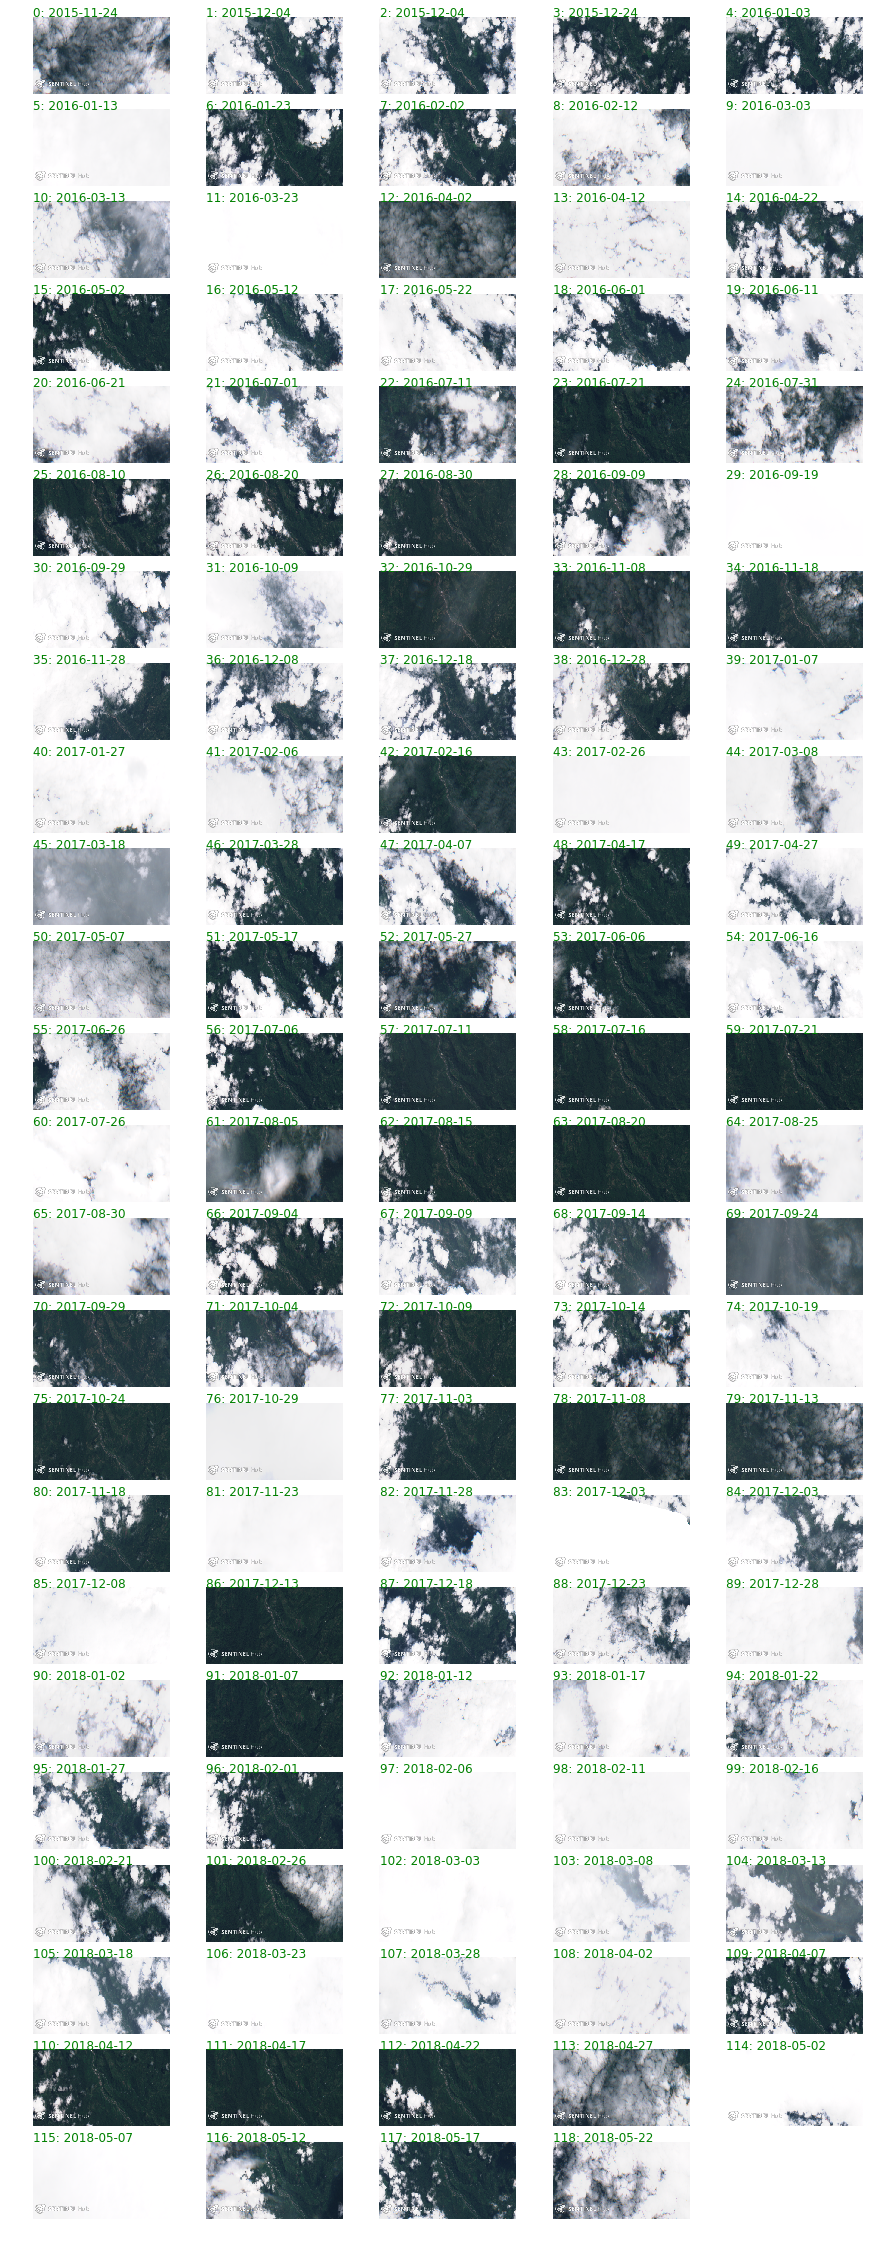

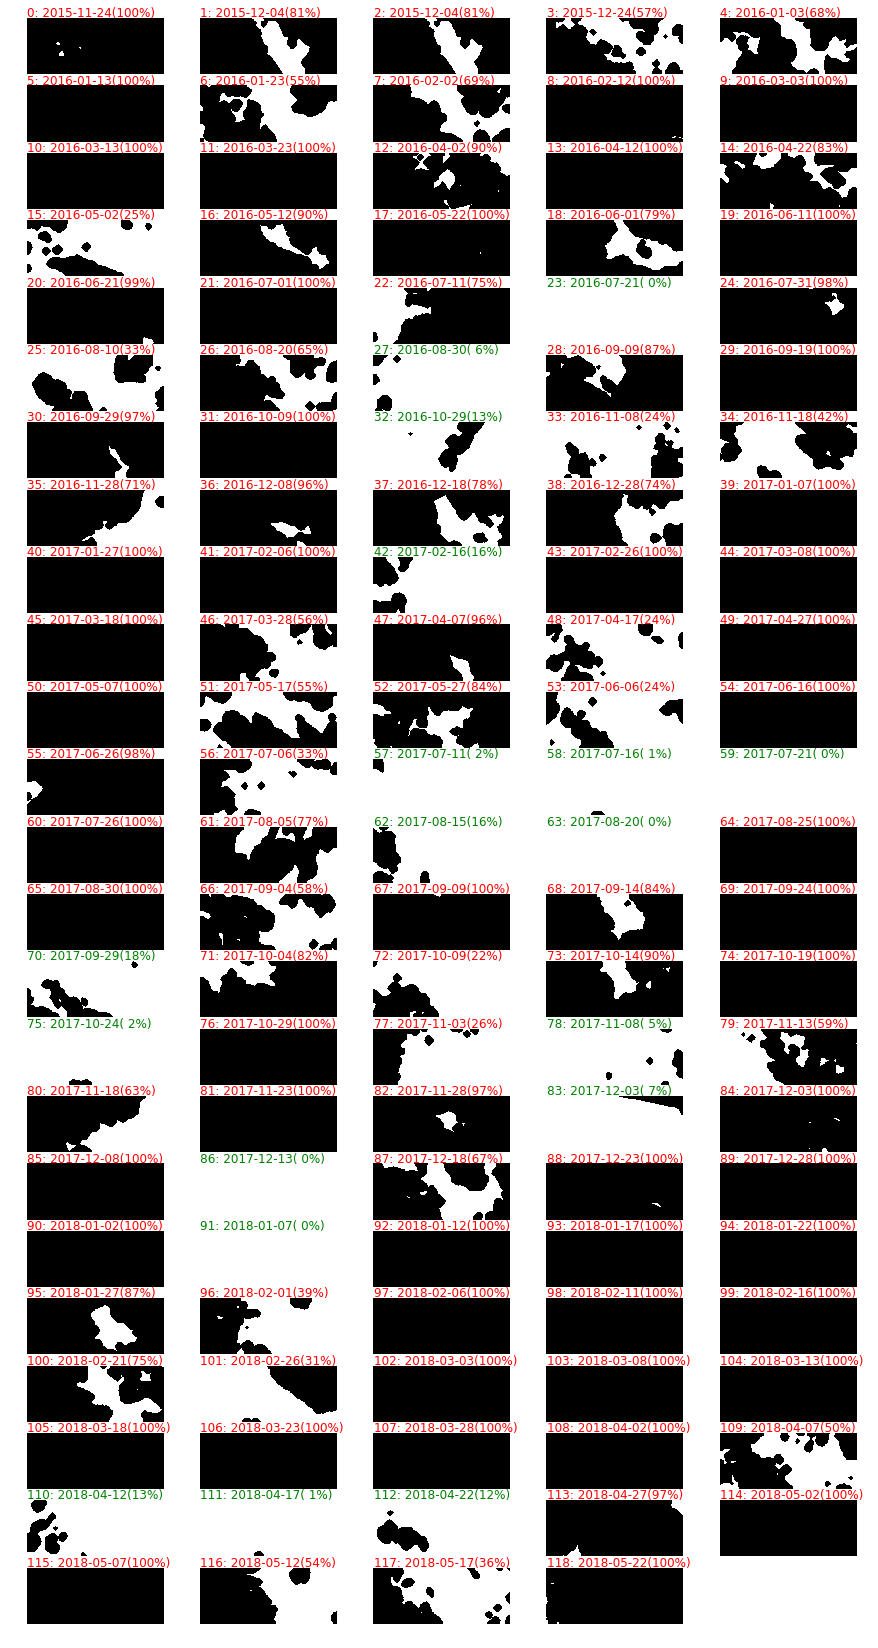

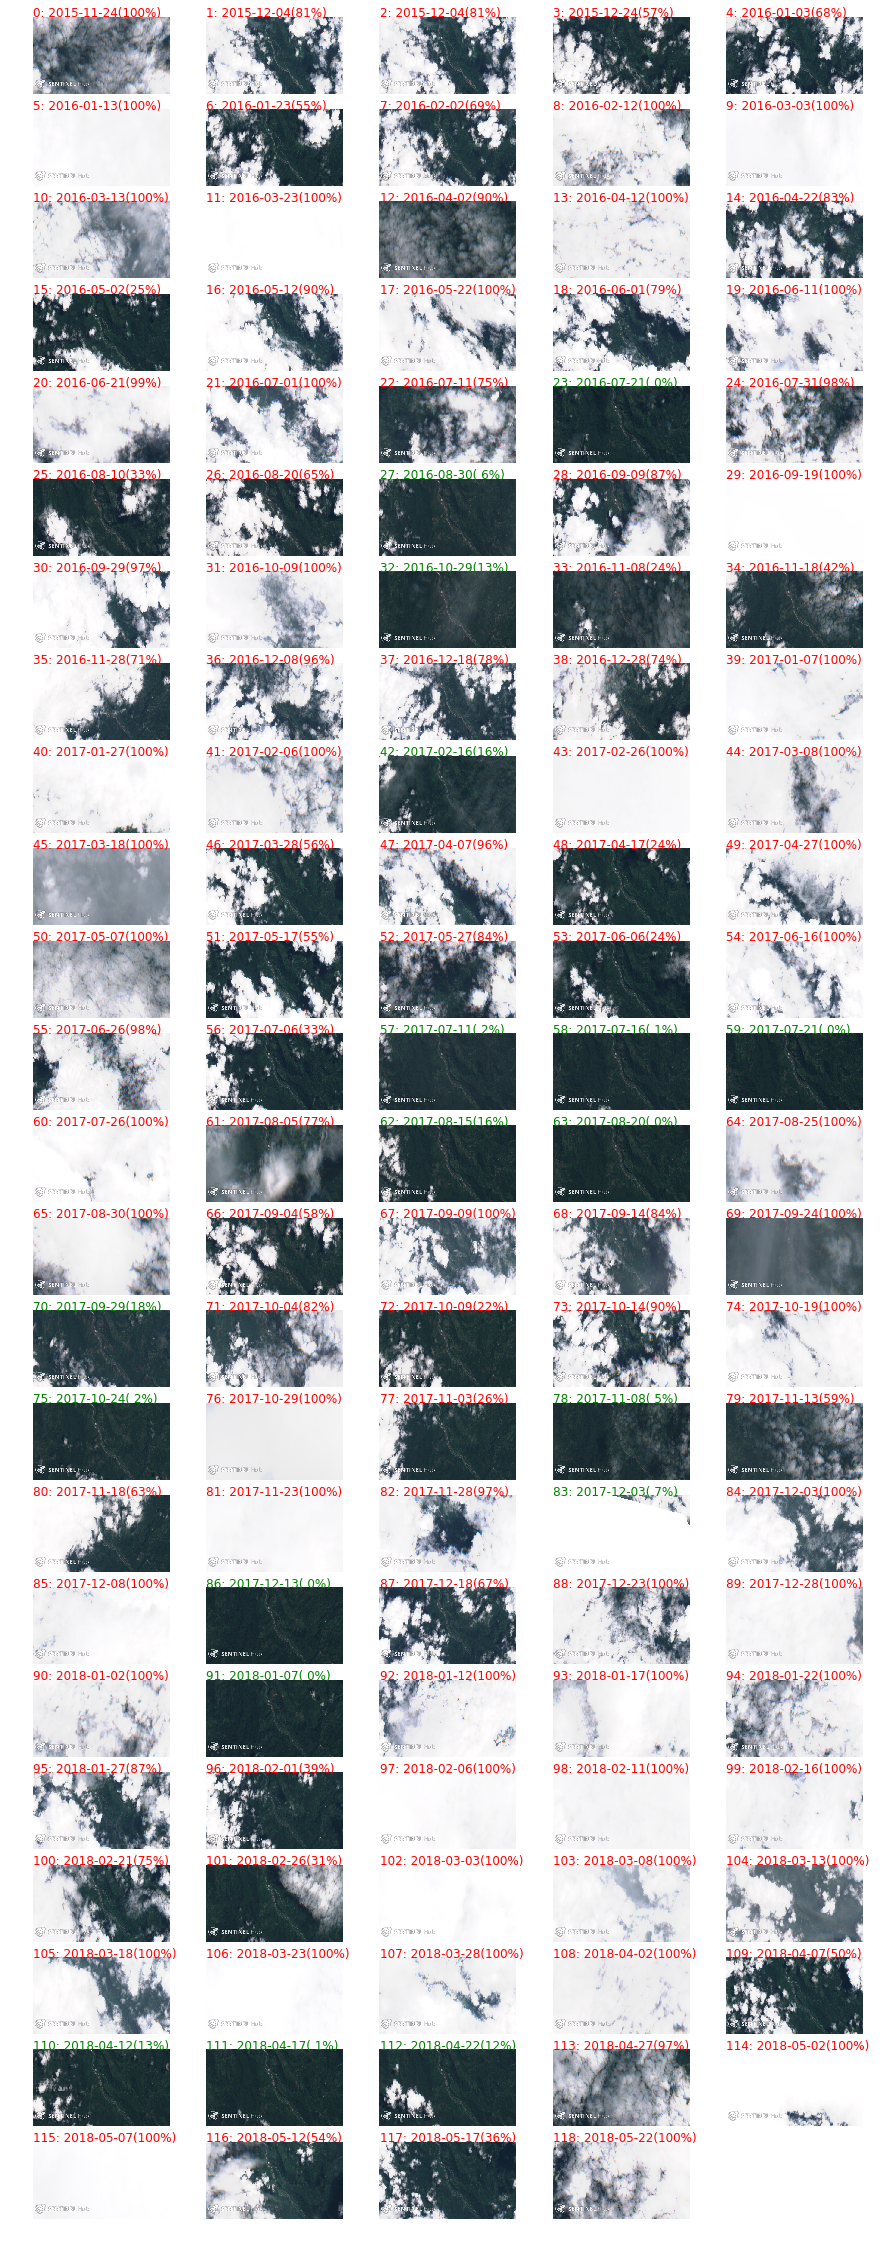

In [25]:
# execute timelapse 
make_timelapse(msg=landslide_name,
               bbox=map_bbox,
               time_interval=time_interval,
               max_cc=cc_thres,
               layer=layer,
               scale_factor=0.2)

### DEM

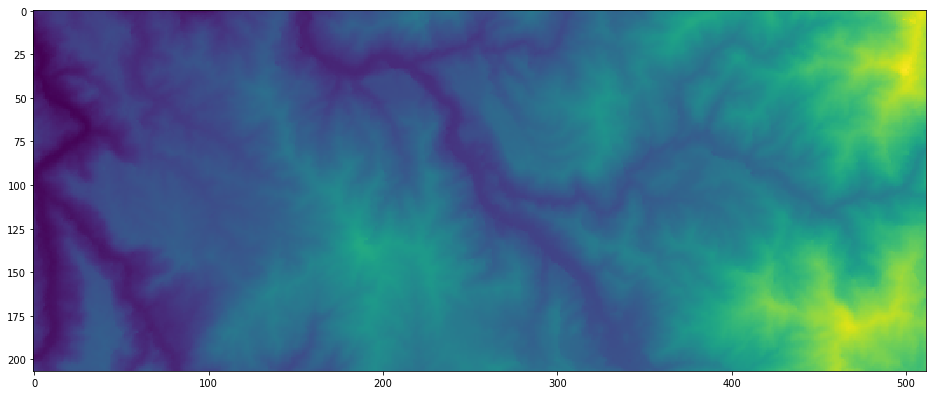

In [11]:
dem_request = WmsRequest(data_source=DataSource.DEM,
                         layer='TRUE-COLOR-DEM',
                         bbox=map_bbox,
                         width=512,
                         instance_id='99adef48-e72e-419b-995a-0ec60dd913d8', # DEM instance ID
                         image_format=MimeType.TIFF_d32f,
                         custom_url_params={CustomUrlParam.SHOWLOGO: False})

dem_image = dem_request.get_data()[0]
plot_image(dem_image,  1./255)

### Sentinel 1

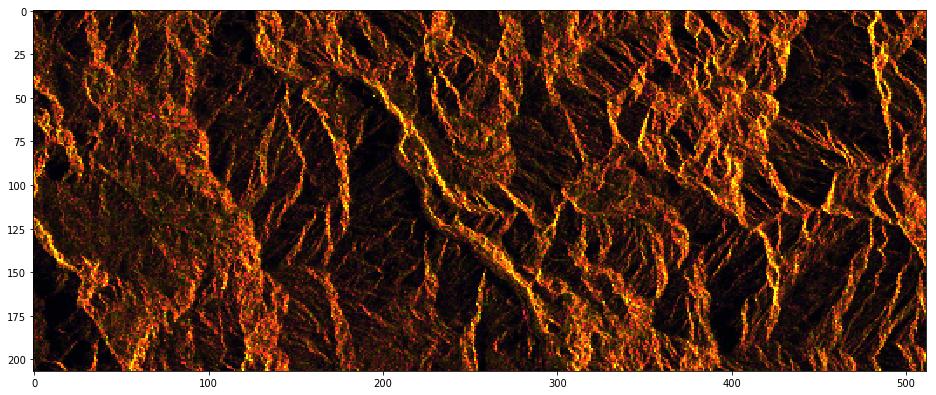

In [14]:
s1_request = WmsRequest(data_source=DataSource.SENTINEL1_IW,
                        layer='TRUE-COLOR-S1-IW',
                        bbox=map_bbox,
                        time=time_interval,
                        width=512,
                        instance_id='13c30a60-b0b5-47b0-a9bf-b97cda6039f4',
                        custom_url_params={CustomUrlParam.SHOWLOGO: False}) # sentinel_1_IW instance ID

s1_data = s1_request.get_data()
plot_image(s1_data[-1],  1./255)

In [18]:
# enquire dates of images
print('These %d images were taken on the following dates:' % len(s1_data))
for index, date in enumerate(s1_request.get_dates()):
    print(' - image %d was taken on %s' % (index, date))

These 75 images were taken on the following dates:
 - image 0 was taken on 2017-07-04 23:36:09
 - image 1 was taken on 2017-07-10 23:36:56
 - image 2 was taken on 2017-07-12 11:00:27
 - image 3 was taken on 2017-07-16 23:36:10
 - image 4 was taken on 2017-07-18 10:59:59
 - image 5 was taken on 2017-07-24 11:00:28
 - image 6 was taken on 2017-07-28 23:36:10
 - image 7 was taken on 2017-08-03 23:36:57
 - image 8 was taken on 2017-08-05 11:00:29
 - image 9 was taken on 2017-08-09 23:36:11
 - image 10 was taken on 2017-08-11 11:00:00
 - image 11 was taken on 2017-08-15 23:36:58
 - image 12 was taken on 2017-08-17 11:00:29
 - image 13 was taken on 2017-08-21 23:36:11
 - image 14 was taken on 2017-08-27 23:36:58
 - image 15 was taken on 2017-08-29 11:00:30
 - image 16 was taken on 2017-09-04 11:00:01
 - image 17 was taken on 2017-09-08 23:36:59
 - image 18 was taken on 2017-09-10 11:00:30
 - image 19 was taken on 2017-09-14 23:36:12
 - image 20 was taken on 2017-09-20 23:36:59
 - image 21 wa

### LandSat (more temporal data)

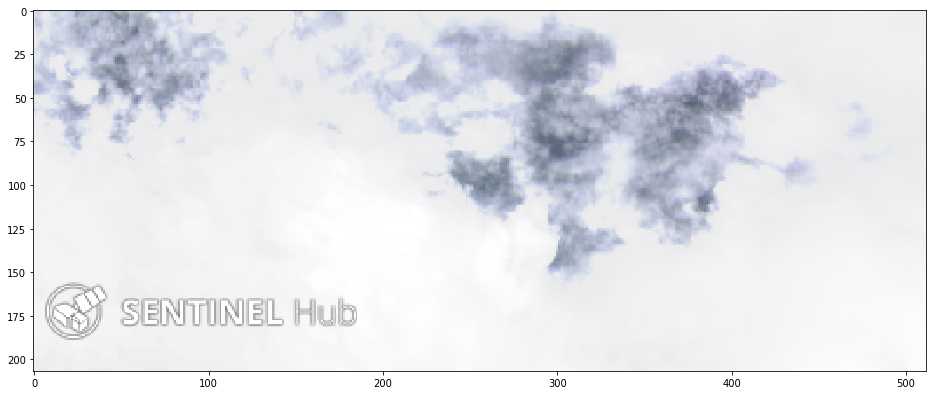

In [15]:
l8_request = WmsRequest(data_source=DataSource.LANDSAT8,
                        layer='1_TRUE_COLOR',
                        bbox=map_bbox,
                        time=time_interval,
                        width=512,
                        instance_id='bc55e38c-67c2-4ffa-a08c-77936ab4035e')

l8_data = l8_request.get_data()
plot_image(l8_data[-1],  1./255)

In [17]:
# enquire dates of images
print('These %d images were taken on the following dates:' % len(l8_data))
for index, date in enumerate(l8_request.get_dates()):
    print(' - image %d was taken on %s' % (index, date))

These 78 images were taken on the following dates:
 - image 0 was taken on 2015-01-02 15:26:20
 - image 1 was taken on 2015-01-18 15:26:18
 - image 2 was taken on 2015-02-03 15:26:14
 - image 3 was taken on 2015-02-19 15:26:07
 - image 4 was taken on 2015-03-07 15:25:59
 - image 5 was taken on 2015-03-23 15:25:50
 - image 6 was taken on 2015-04-08 15:25:40
 - image 7 was taken on 2015-04-24 15:25:37
 - image 8 was taken on 2015-05-10 15:25:22
 - image 9 was taken on 2015-05-26 15:25:22
 - image 10 was taken on 2015-06-11 15:25:33
 - image 11 was taken on 2015-06-27 15:25:39
 - image 12 was taken on 2015-07-13 15:25:50
 - image 13 was taken on 2015-07-29 15:25:55
 - image 14 was taken on 2015-08-14 15:26:00
 - image 15 was taken on 2015-08-30 15:26:06
 - image 16 was taken on 2015-09-15 15:26:14
 - image 17 was taken on 2015-10-01 15:26:19
 - image 18 was taken on 2015-10-17 15:26:19
 - image 19 was taken on 2015-11-02 15:26:25
 - image 20 was taken on 2015-11-18 15:26:26
 - image 21 wa

### GBDX API

In [2]:
# import libs
import itertools

# Shapely and Rasterio for processing geometries
from shapely import geometry
from shapely.geometry import box, shape, Polygon
from shapely.ops import cascaded_union
from rasterio import features   

# GBDX
from gbdxtools import Interface
from gbdxtools.task import env
from gbdxtools import CatalogImage

# array operations and plotting
import numpy as np
import matplotlib.pyplot as plt
# matplot lib settings
%matplotlib inline 

# scikit-image modules for image science operators
from skimage import filters, morphology

# Initialize gbdx interface
gbdx = Interface()#username='vilhelm.stiernstedt@student.ie.edu',
                 #password='superSNOW15@',
                 #client_id='fb67ad6d-6e27-4bac-8f8c-d8e8485effa3',
                 #client_secret='')

In [ ]:
# CatalogImages -> pointer to desired data
catalog_id = env.inputs.get('catalog_id', '1030010006074900')

# define coordinates 
bbox = env.inputs.get('bbox', '-70.623, 41.422, -70.534, 41.501')

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")))
image.plot(w=10, h=10)

